In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use(["classic"])

mpl.rc( 'lines', linewidth=3 )
mpl.rc( 'font', family='monospace', weight='normal', size=20 )

c_frame = (0,0,0,.8)
for tick in 'xtick', 'ytick':
    mpl.rc( tick+'.major', width=1.5, size=8)
    mpl.rc( tick+'.minor', width=1, size=4, visible=True )
    mpl.rc( tick, color=c_frame, labelsize=18, direction='in' )
mpl.rc( 'xtick', top=True )
mpl.rc( 'ytick', right=True )
mpl.rc( 'axes', linewidth=1.5, edgecolor=c_frame, labelweight='normal' )
mpl.rc( 'grid', color=c_frame)
mpl.rc( 'patch', edgecolor=c_frame)

In [9]:
def prop_bin(x_prop, y_prop, x_edges, sig_num = 1):
    '''
    Bin datas into bins of x_prop, and calculate the median value of y_prop in each bin with error.
    '''
    
    #   Exclude the data with nan and inf
    finite_ind = np.isfinite(x_prop) & np.isfinite(y_prop)
    x_prop = x_prop[finite_ind]
    y_prop = y_prop[finite_ind]

    #   Calculate the median value of y_prop in each bin
    bin_mid = (x_edges[:-1] + x_edges[1:]) / 2
    prop_cnt = binned_statistic(x_prop, y_prop,statistic='count', bins=x_edges).statistic
    prop_mid = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='median', bins=x_edges).statistic, np.nan)
    prop_std = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='std', bins=x_edges).statistic, np.nan)
    prop_err = 1.253 * prop_std / np.sqrt(prop_cnt)

    return bin_mid, prop_mid, prop_err

def moving_average(x_prop, y_prop, y_err, ave_step):
    y_prop_ave = pd.DataFrame(y_prop).rolling(ave_step, center=True, min_periods=1).mean().values.flatten()
    ind_finite = np.isfinite(y_prop)
    return x_prop[ind_finite], y_prop_ave[ind_finite], y_err[ind_finite]

def ave_bin(x_prop, y_prop, x_edges, x_min, ave_step, sig_num = 1):
    x_mid, y_mid, y_err = prop_bin(x_prop, y_prop, x_edges, sig_num = sig_num)
    x_mid_ave, y_mid_ave, y_err_ave = moving_average(x_mid, y_mid, y_err, ave_step)
    return x_mid_ave[x_mid_ave >= x_min], y_mid_ave[x_mid_ave >= x_min], y_err_ave[x_mid_ave >= x_min]

# Data

In [5]:
# MPA-JHU catalog
mpa_gals_weight_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/sdss_gals_weight.csv')
mpa_gals_weighted_df = mpa_gals_weight_df.sample(
    n=int(mpa_gals_weight_df.v_vmax.sum()), weights=mpa_gals_weight_df.v_vmax, replace=True).reset_index(drop=True)
# Firefly catalog
firefly_gals_weight_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_gals_weight.csv')
firefly_gals_weighted_df = firefly_gals_weight_df.sample(
    n=int(firefly_gals_weight_df.v_vmax.sum()), weights=firefly_gals_weight_df.v_vmax, replace=True).reset_index(drop=True)

In [8]:
mpa_sf_df, mpa_gv_df, mpa_q_df = mpa_gals_weighted_df[mpa_gals_weighted_df.gal_class == 'SF'].reset_index(drop=True), \
                                mpa_gals_weighted_df[mpa_gals_weighted_df.gal_class == 'GV'].reset_index(drop=True), \
                                mpa_gals_weighted_df[mpa_gals_weighted_df.gal_class == 'Q'].reset_index(drop=True)
firefly_sf_df, firefly_gv_df, firefly_q_df = firefly_gals_weighted_df[firefly_gals_weighted_df.gal_class == 'SF'].reset_index(drop=True), \
                                            firefly_gals_weighted_df[firefly_gals_weighted_df.gal_class == 'GV'].reset_index(drop=True), \
                                            firefly_gals_weighted_df[firefly_gals_weighted_df.gal_class == 'Q'].reset_index(drop=True)

In [12]:
m_star_edges = np.arange(9, 12.02,0.02)
sig_num = 30
m_th_sf, m_th_gv, m_th_q = 9, 9.7, 9.5
#  Stellar Metallicity
mz_mpa_sf, z_mpa_sf, z_err_mpa_sf = ave_bin(
    x_prop = mpa_sf_df.log_m_star.values, y_prop = mpa_sf_df.log_z_star.values, 
    x_edges = m_star_edges, x_min=m_th_sf, ave_step = 10, sig_num = sig_num)
mz_mpa_gv, z_mpa_gv, z_err_mpa_gv = ave_bin(
    x_prop = mpa_gv_df.log_m_star.values, y_prop = mpa_gv_df.log_z_star.values,
    x_edges = m_star_edges, x_min=m_th_gv, ave_step = 10, sig_num = sig_num)
mz_mpa_q, z_mpa_q, z_err_mpa_q = ave_bin(
    x_prop = mpa_q_df.log_m_star.values, y_prop = mpa_q_df.log_z_star.values,
    x_edges = m_star_edges, x_min=m_th_q, ave_step = 10, sig_num = sig_num)
mz_firefly_sf, z_firefly_sf, z_err_firefly_sf = ave_bin(
    x_prop = firefly_sf_df.log_m_star.values, y_prop = firefly_sf_df.log_z_star.values,
    x_edges = m_star_edges, x_min=m_th_sf, ave_step = 10, sig_num = sig_num)
mz_firefly_gv, z_firefly_gv, z_err_firefly_gv = ave_bin(
    x_prop = firefly_gv_df.log_m_star.values, y_prop = firefly_gv_df.log_z_star.values,
    x_edges = m_star_edges, x_min=m_th_gv, ave_step = 10, sig_num = sig_num)
mz_firefly_q, z_firefly_q, z_err_firefly_q = ave_bin(
    x_prop = firefly_q_df.log_m_star.values, y_prop = firefly_q_df.log_z_star.values,
    x_edges = m_star_edges, x_min=m_th_q, ave_step = 10, sig_num = sig_num)

#  Stellar Age
ma_mpa_sf, a_mpa_sf, a_err_mpa_sf = ave_bin(
    x_prop = mpa_sf_df.log_m_star.values, y_prop = mpa_sf_df.lw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_sf, ave_step = 10, sig_num = sig_num)
ma_mpa_gv, a_mpa_gv, a_err_mpa_gv = ave_bin(
    x_prop = mpa_gv_df.log_m_star.values, y_prop = mpa_gv_df.lw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_gv, ave_step = 10, sig_num = sig_num)
ma_mpa_q, a_mpa_q, a_err_mpa_q = ave_bin(
    x_prop = mpa_q_df.log_m_star.values, y_prop = mpa_q_df.lw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_q, ave_step = 10, sig_num = sig_num)
ma_firefly_sf, a_firefly_sf, a_err_firefly_sf = ave_bin(
    x_prop = firefly_sf_df.log_m_star.values, y_prop = firefly_sf_df.mw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_sf, ave_step = 10, sig_num = sig_num)
ma_firefly_gv, a_firefly_gv, a_err_firefly_gv = ave_bin(
    x_prop = firefly_gv_df.log_m_star.values, y_prop = firefly_gv_df.mw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_gv, ave_step = 10, sig_num = sig_num)
ma_firefly_q, a_firefly_q, a_err_firefly_q = ave_bin(
    x_prop = firefly_q_df.log_m_star.values, y_prop = firefly_q_df.mw_age_gyr.values,
    x_edges = m_star_edges, x_min=m_th_q, ave_step = 10, sig_num = sig_num)

In [86]:
mpl.rcParams['lines.linewidth'] = 1.2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.marker'] = 'None'
mpl.rcParams['errorbar.capsize'] = 0.6
mpl.rcParams['grid.alpha'] = 0.6
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 18

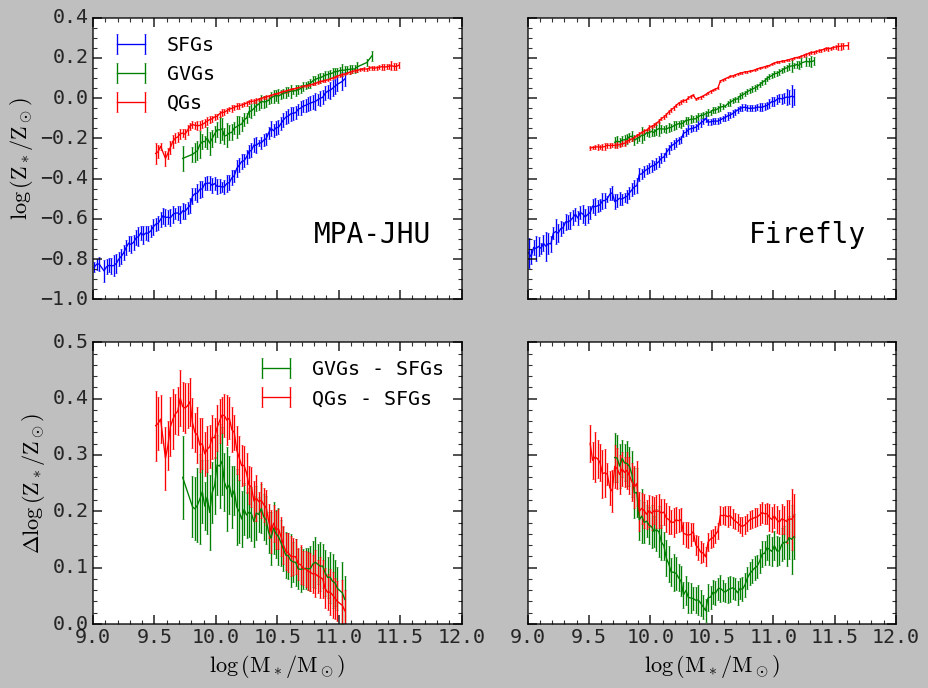

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
ax1, ax2, ax3, ax4 = axes.flatten()

# ax1: MPA-JHU Stellar Metallicity
ax1.errorbar(mz_mpa_sf, z_mpa_sf, yerr=z_err_mpa_sf, c='b', label='SFGs', ls='-', )
ax1.errorbar(mz_mpa_gv, z_mpa_gv, yerr=z_err_mpa_gv, c='g', label='GVGs', ls='-', )
ax1.errorbar(mz_mpa_q, z_mpa_q, yerr=z_err_mpa_q, c='r', label='QGs', ls='-', )

# ax2: Firefly Stellar Metallicity
ax2.errorbar(mz_firefly_sf, z_firefly_sf, yerr=z_err_firefly_sf, c='b', label='SFGs', ls='-', )
ax2.errorbar(mz_firefly_gv, z_firefly_gv, yerr=z_err_firefly_gv, c='g', label='GVGs', ls='-', )
ax2.errorbar(mz_firefly_q, z_firefly_q, yerr=z_err_firefly_q, c='r', label='QGs', ls='-', )

# ax3: Delta MPA-JHU Stellar Metallicity
mz_mpa_sf_gv, indz_mpa_gv_sf, indz_mpa_sf_gv = np.intersect1d(mz_mpa_sf, mz_mpa_gv, return_indices = True, assume_unique = True)
mz_mpa_sf_q, indz_mpa_q_sf, indz_mpa_sf_q = np.intersect1d(mz_mpa_sf, mz_mpa_q, return_indices = True, assume_unique = True)
ax3.errorbar(mz_mpa_sf_gv, z_mpa_gv[indz_mpa_sf_gv] - z_mpa_sf[indz_mpa_gv_sf],
                yerr=np.sqrt(z_err_mpa_gv[indz_mpa_sf_gv]**2 + z_err_mpa_sf[indz_mpa_gv_sf]**2),
                 c='g', label='GVGs - SFGs', ls='-',)
ax3.errorbar(mz_mpa_sf_q, z_mpa_q[indz_mpa_sf_q] - z_mpa_sf[indz_mpa_q_sf],
                yerr=np.sqrt(z_err_mpa_q[indz_mpa_sf_q]**2 + z_err_mpa_sf[indz_mpa_q_sf]**2),
                c='r', label='QGs - SFGs', ls='-',)



# ax4: Delta Firefly Stellar Metallicity
mz_firefly_sf_gv, indz_firefly_gv_sf, indz_firefly_sf_gv = np.intersect1d(mz_firefly_sf, mz_firefly_gv, return_indices = True, assume_unique = True)
mz_firefly_sf_q, indz_firefly_q_sf, indz_firefly_sf_q = np.intersect1d(mz_firefly_sf, mz_firefly_q, return_indices = True, assume_unique = True)
ax4.errorbar(mz_firefly_sf_gv, z_firefly_gv[indz_firefly_sf_gv] - z_firefly_sf[indz_firefly_gv_sf],
                yerr=np.sqrt(z_err_firefly_gv[indz_firefly_sf_gv]**2 + z_err_firefly_sf[indz_firefly_gv_sf]**2),
                    c='g', label='GVGs - SFGs', ls='-',)
ax4.errorbar(mz_firefly_sf_q, z_firefly_q[indz_firefly_sf_q] - z_firefly_sf[indz_firefly_q_sf],
                yerr=np.sqrt(z_err_firefly_q[indz_firefly_sf_q]**2 + z_err_firefly_sf[indz_firefly_q_sf]**2),
                    c='r', label='QGs - SFGs', ls='-',)


ax1.legend(loc='upper left')
ax3.legend()
ax1.text(0.6, 0.2, 'MPA-JHU', transform=ax1.transAxes, fontsize=25)
ax2.text(0.6, 0.2, 'Firefly', transform=ax2.transAxes, fontsize=25)

for ax in [ax1, ax2]:
    ax.set_ylim(-1., 0.4)
    ax.set_ylabel(r'$\log \rm (Z_*/Z_\odot)$')
for ax in [ax3, ax4]:
    ax.set_ylim(0., 0.5)
    ax.set_ylabel(r'$\Delta \log \rm (Z_*/Z_\odot)$')

for ax in axes.flatten():
    ax.set_xlim(9, 12)
    ax.set_xlabel(r'$\log \rm (M_* / M_\odot)$')
    ax.label_outer()

fig.tight_layout()
plt.savefig('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/z_mstar.pdf', dpi=300, format='pdf', bbox_inches='tight')

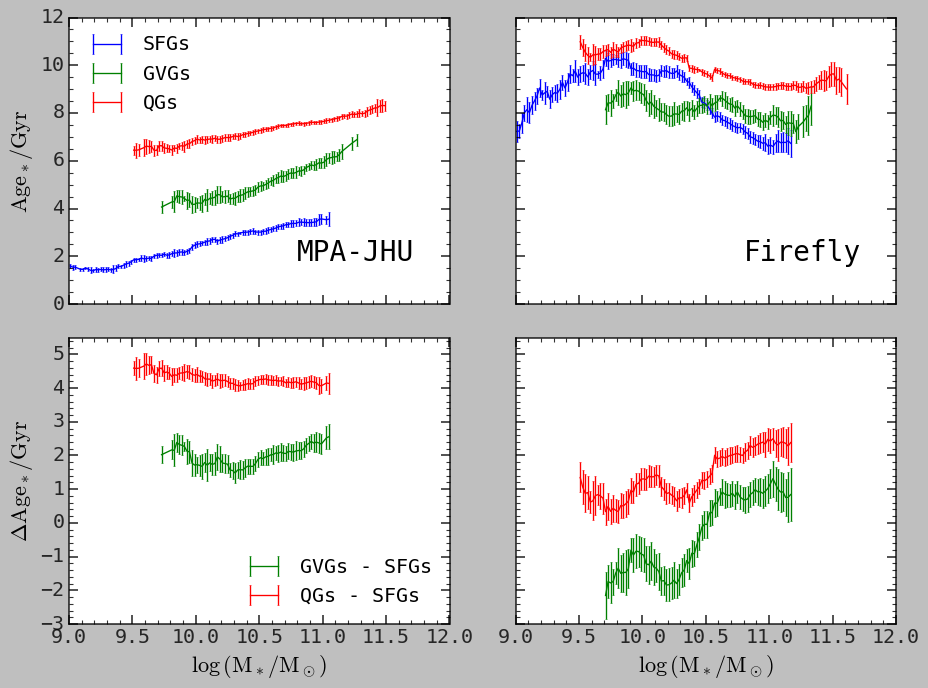

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
ax1, ax2, ax3, ax4 = axes.flatten()

# ax1: MPA-JHU Stellar Age
ax1.errorbar(ma_mpa_sf, a_mpa_sf, yerr=a_err_mpa_sf, c='b', label='SFGs', ls='-', )
ax1.errorbar(ma_mpa_gv, a_mpa_gv, yerr=a_err_mpa_gv, c='g', label='GVGs', ls='-', )
ax1.errorbar(ma_mpa_q, a_mpa_q, yerr=a_err_mpa_q, c='r', label='QGs', ls='-', )

# ax2: Firefly Stellar Age
ax2.errorbar(ma_firefly_sf, a_firefly_sf, yerr=a_err_firefly_sf, c='b', label='SFGs', ls='-', )
ax2.errorbar(ma_firefly_gv, a_firefly_gv, yerr=a_err_firefly_gv, c='g', label='GVGs', ls='-', )
ax2.errorbar(ma_firefly_q, a_firefly_q, yerr=a_err_firefly_q, c='r', label='QGs', ls='-', )

# ax3: Delta MPA-JHU Stellar Age   
ma_mpa_sf_gv, inda_mpa_gv_sf, inda_mpa_sf_gv = np.intersect1d(ma_mpa_sf, ma_mpa_gv, return_indices = True, assume_unique = True)
ma_mpa_sf_q, inda_mpa_q_sf, inda_mpa_sf_q = np.intersect1d(ma_mpa_sf, ma_mpa_q, return_indices = True, assume_unique = True)
ax3.errorbar(ma_mpa_sf_gv, a_mpa_gv[inda_mpa_sf_gv] - a_mpa_sf[inda_mpa_gv_sf],
                yerr=np.sqrt(a_err_mpa_gv[inda_mpa_sf_gv]**2 + a_err_mpa_sf[inda_mpa_gv_sf]**2),
                    c='g', label='GVGs - SFGs', ls='-',)
ax3.errorbar(ma_mpa_sf_q, a_mpa_q[inda_mpa_sf_q] - a_mpa_sf[inda_mpa_q_sf],
                yerr=np.sqrt(a_err_mpa_q[inda_mpa_sf_q]**2 + a_err_mpa_sf[inda_mpa_q_sf]**2),
                    c='r', label='QGs - SFGs', ls='-',)

# ax4: Delta Firefly Stellar Age
ma_firefly_sf_gv, inda_firefly_gv_sf, inda_firefly_sf_gv = np.intersect1d(ma_firefly_sf, ma_firefly_gv, return_indices = True, assume_unique = True)
ma_firefly_sf_q, inda_firefly_q_sf, inda_firefly_sf_q = np.intersect1d(ma_firefly_sf, ma_firefly_q, return_indices = True, assume_unique = True)
ax4.errorbar(ma_firefly_sf_gv, a_firefly_gv[inda_firefly_sf_gv] - a_firefly_sf[inda_firefly_gv_sf],
                yerr=np.sqrt(a_err_firefly_gv[inda_firefly_sf_gv]**2 + a_err_firefly_sf[inda_firefly_gv_sf]**2),
                c='g', label='GVGs - SFGs', ls='-',)
ax4.errorbar(ma_firefly_sf_q, a_firefly_q[inda_firefly_sf_q] - a_firefly_sf[inda_firefly_q_sf],
                yerr=np.sqrt(a_err_firefly_q[inda_firefly_sf_q]**2 + a_err_firefly_sf[inda_firefly_q_sf]**2),
                c='r', label='QGs - SFGs', ls='-',)

ax1.legend(loc='upper left')
ax3.legend(loc='lower right')
ax1.text(0.6, 0.15, 'MPA-JHU', transform=ax1.transAxes, fontsize=25)
ax2.text(0.6, 0.15, 'Firefly', transform=ax2.transAxes, fontsize=25)
                
for ax in [ax1, ax2]:
    ax.set_ylim(0., 12)
    ax.set_ylabel(r'$\rm Age_*/Gyr$')
for ax in [ax3, ax4]:
    ax.set_ylim(-3., 5.5)
    ax.set_ylabel(r'$\Delta \rm Age_*/Gyr$')

for ax in axes.flatten():
    ax.set_xlim(9, 12)
    ax.set_xlabel(r'$\log \rm (M_* / M_\odot)$')
    ax.label_outer()

fig.tight_layout()
plt.savefig('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/age_mstar.pdf', dpi=300, format='pdf', bbox_inches='tight')